In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, max_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [9]:
df_option = pd.read_pickle("AAPL_trainning_master_data.pkl")

In [10]:
df_option.columns

Index(['Target_std', 'Target_spread', 'prior_std', 'prior_Vol', 'prior_spread',
       'prior_range', 'cut_close', 'cut_1hr', 'cut_2hr', 'cut_3hr',
       'vix_prior_std', 'vix_pr_spread', 'vix_prior_range', 'vix_cut_open',
       'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr', 'tqqq_prior_std',
       'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range', 'tqqq_cut_open',
       'tqqq_cut_1hr', 'tqqq_cut_2hr', 'tqqq_cut_3hr'],
      dtype='object')

In [11]:
len(df_option.columns)

25

<Axes: >

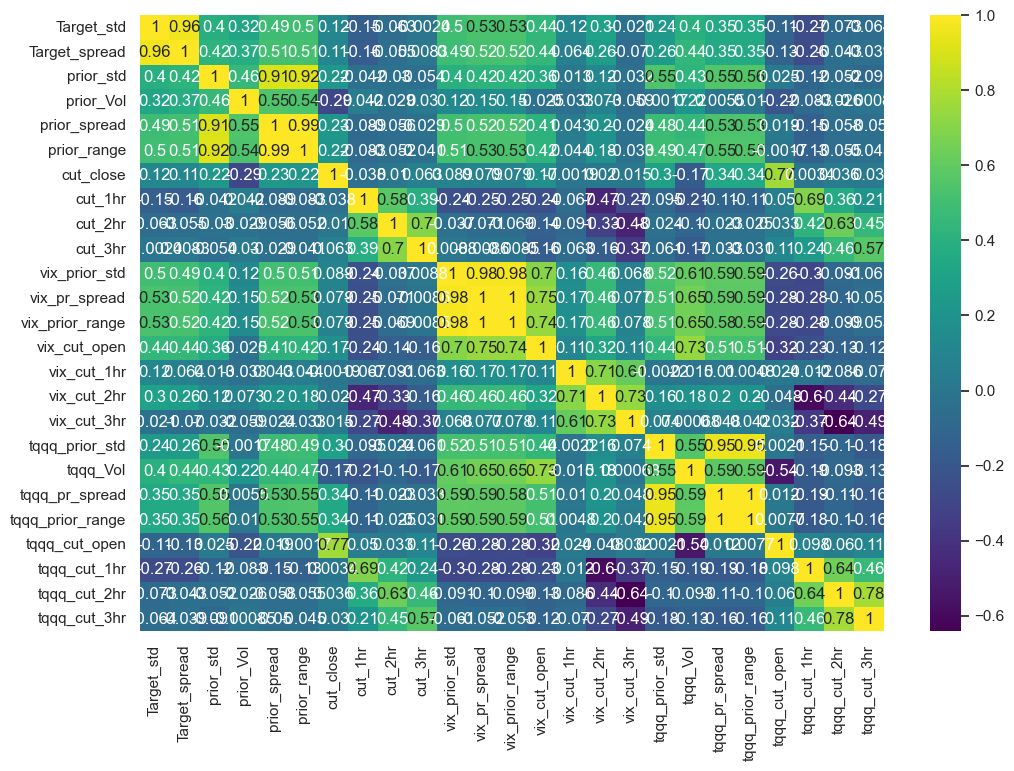

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(df_option.corr(numeric_only=True),cmap='viridis',annot=True)

<Axes: ylabel='Frequency'>

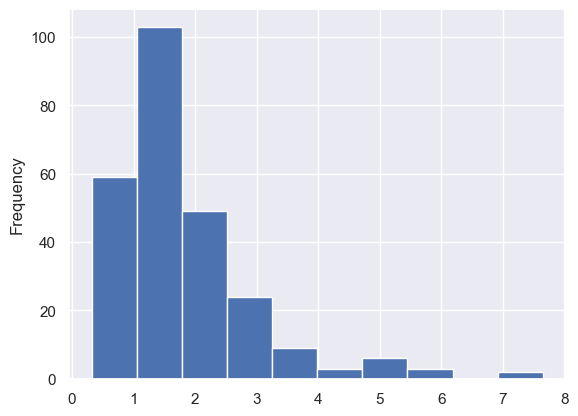

In [13]:
df_option.Target_spread.plot.hist()

In [7]:
#sns.catplot(x='OP_EXP',y='Target_std',data=df_option, kind='box')

In [14]:
df_option.reset_index(inplace=True)

## Splitting the Data


In [15]:
X = df_option.drop(['Date_Only','Target_std','Target_spread'], axis=1)  
#y = df_option['Target_std']
y = df_option['Target_spread']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [17]:
X_train.columns

Index(['prior_std', 'prior_Vol', 'prior_spread', 'prior_range', 'cut_close',
       'cut_1hr', 'cut_2hr', 'cut_3hr', 'vix_prior_std', 'vix_pr_spread',
       'vix_prior_range', 'vix_cut_open', 'vix_cut_1hr', 'vix_cut_2hr',
       'vix_cut_3hr', 'tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread',
       'tqqq_prior_range', 'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr',
       'tqqq_cut_3hr'],
      dtype='object')

In [18]:
X_train.shape

(206, 23)

In [19]:
y_train.shape

(206,)

## Evaluation Run Model with the Data


In [20]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test,preds)
    print(f'mae : {mae}')
   
    
    plt.figure(figsize=(12,8),dpi=200)
    plt.scatter(y_test, preds)
    plt.plot(y_test, y_test, color='green', linestyle='dashed')
    plt.xlabel('real_std')

    return model

----

## Support Vector Regression

In [21]:
from sklearn.svm import SVR

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
scaler = StandardScaler()
sc_X_train = scaler.fit_transform(X_train)
sc_X_test = scaler.transform(X_test)

In [24]:
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}
svr = SVR()

In [25]:
grid = GridSearchCV(svr,param_grid)

mae : 0.7112328514618587


GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 100, 1000],
                         'gamma': ['auto', 'scale']})

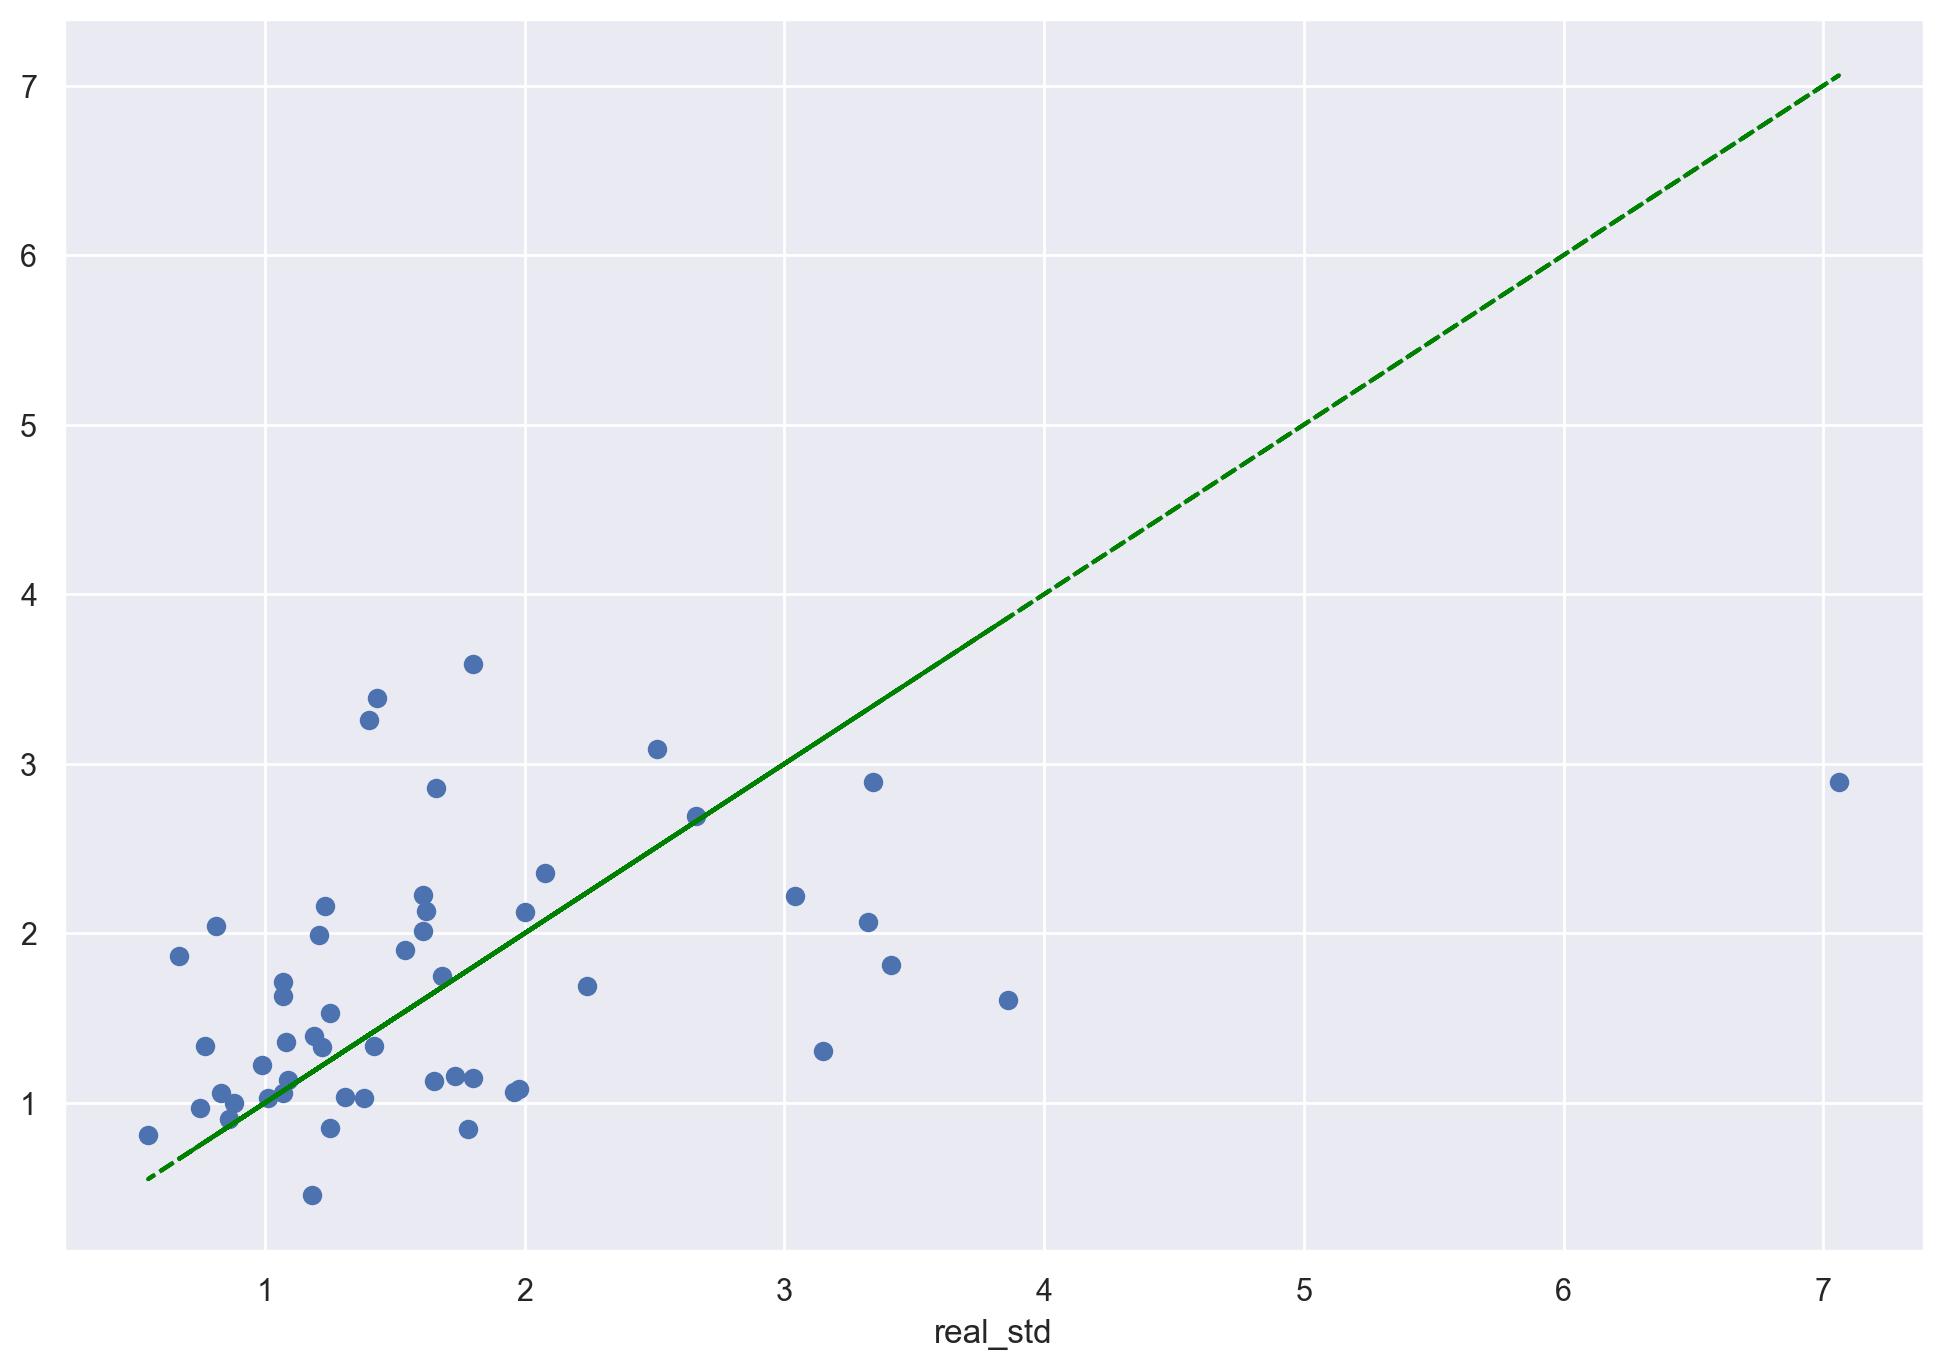

In [26]:
run_model(grid,sc_X_train,y_train,sc_X_test,y_test)

In [27]:
scaler_filename = "scaler4svr_APPL.save"
joblib.dump(scaler, scaler_filename)

['scaler4svr_APPL.save']

In [28]:
SVR_model = grid.best_estimator_

In [29]:
filename = 'SVR_model_APPL.joblib'
joblib.dump(SVR_model, filename)

['SVR_model_APPL.joblib']

---

## Random Forest Regression

## Gradient Boosting


In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
# help(GradientBoostingRegressor)

mae : 0.7035204760903397


GradientBoostingRegressor()

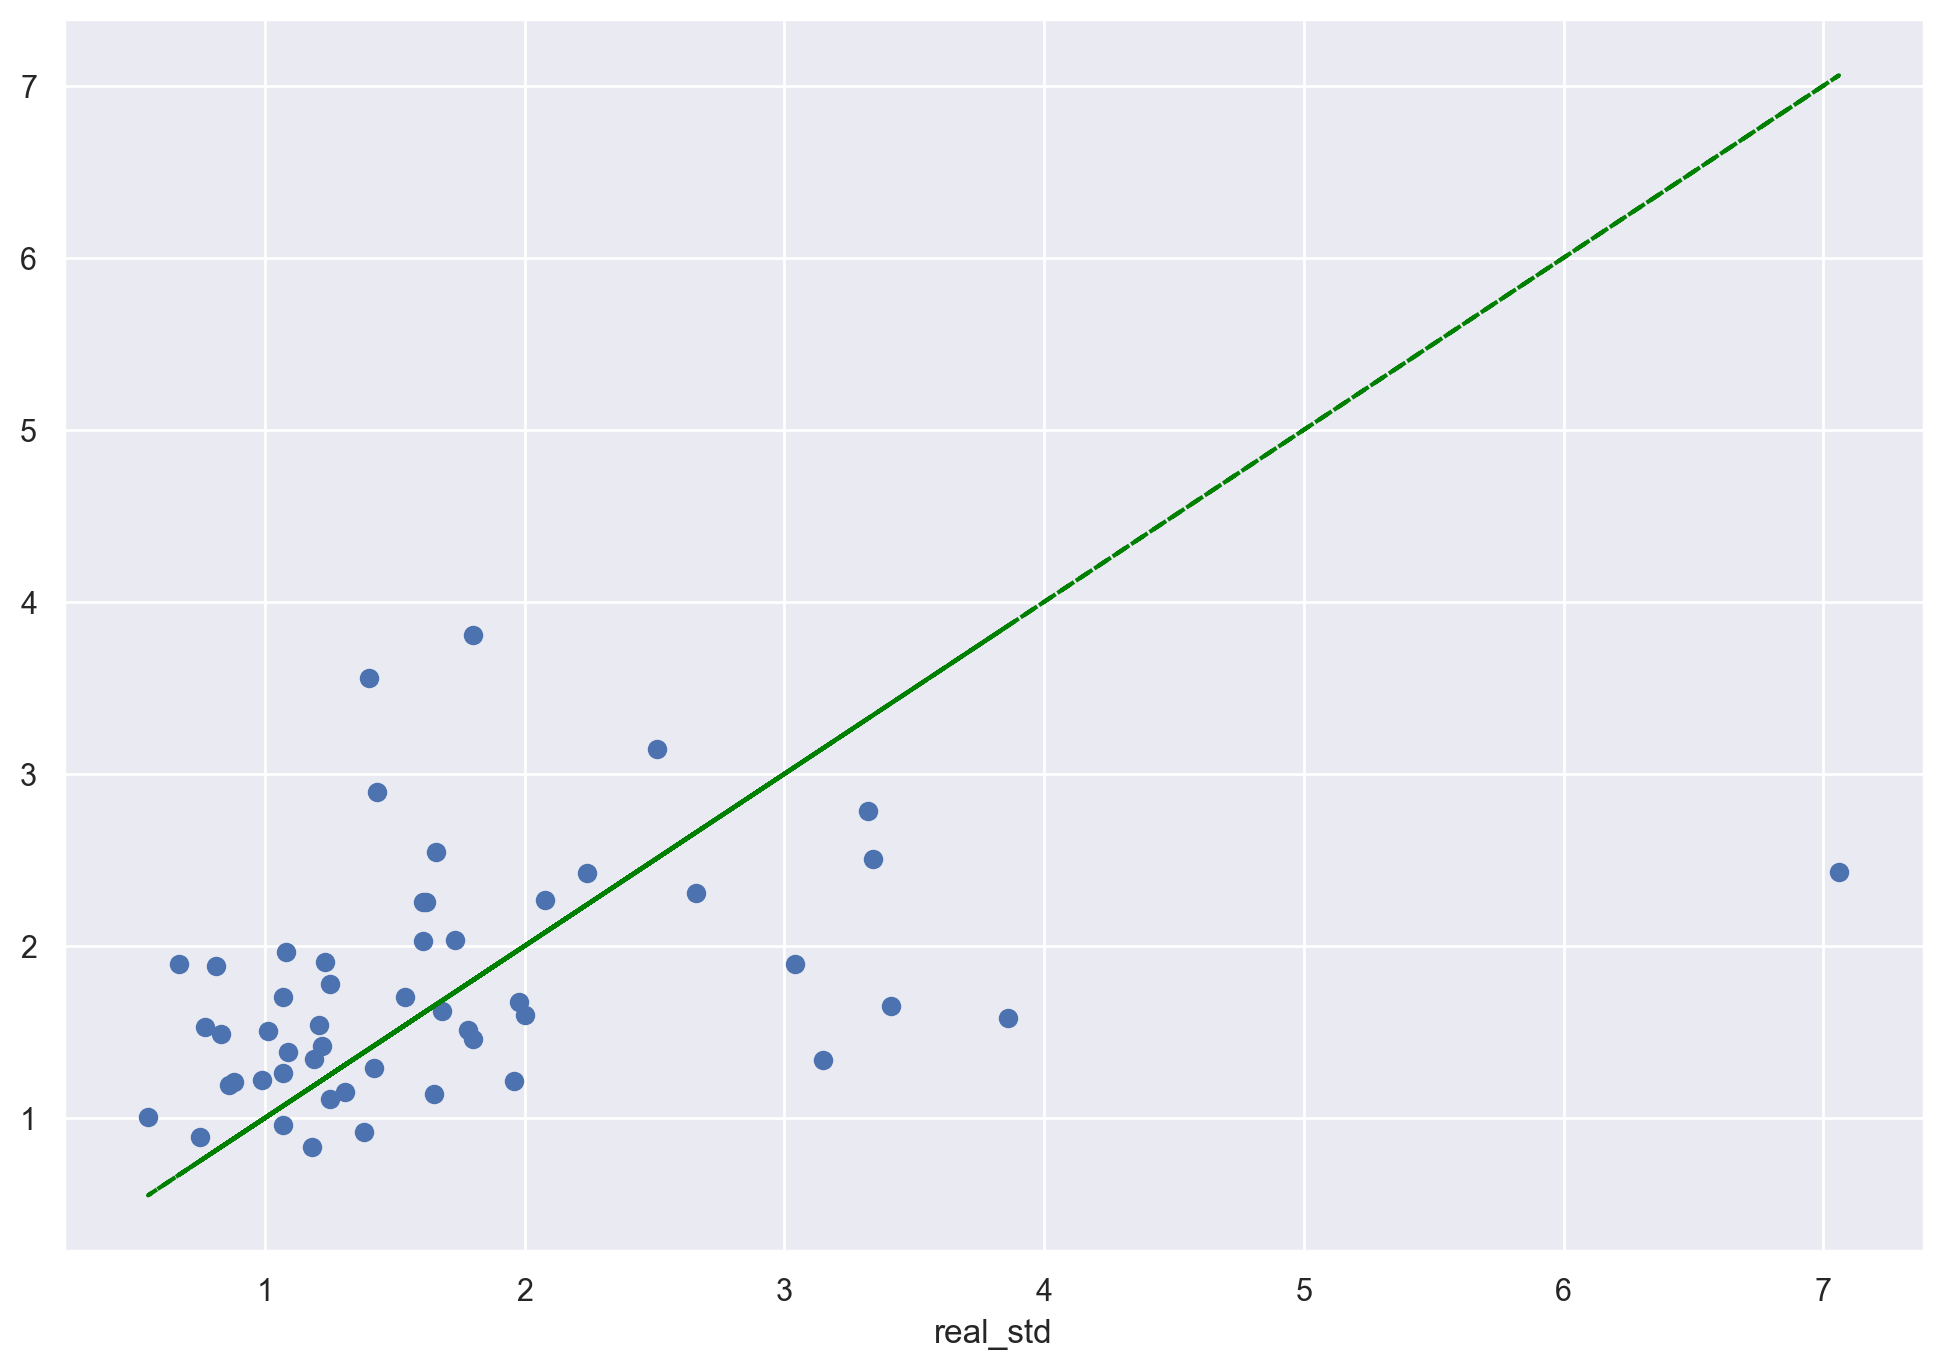

In [32]:
   
model = GradientBoostingRegressor()

run_model(model,X_train,y_train,X_test,y_test)

In [33]:
import xgboost as xgb
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Initialize XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=10,
                           verbose=0,
                          n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

# Evaluate the best model on the test set
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Best score: 0.9182662588145846
Test RMSE: 1.0616326408869956


mae : 0.6909201377171718


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

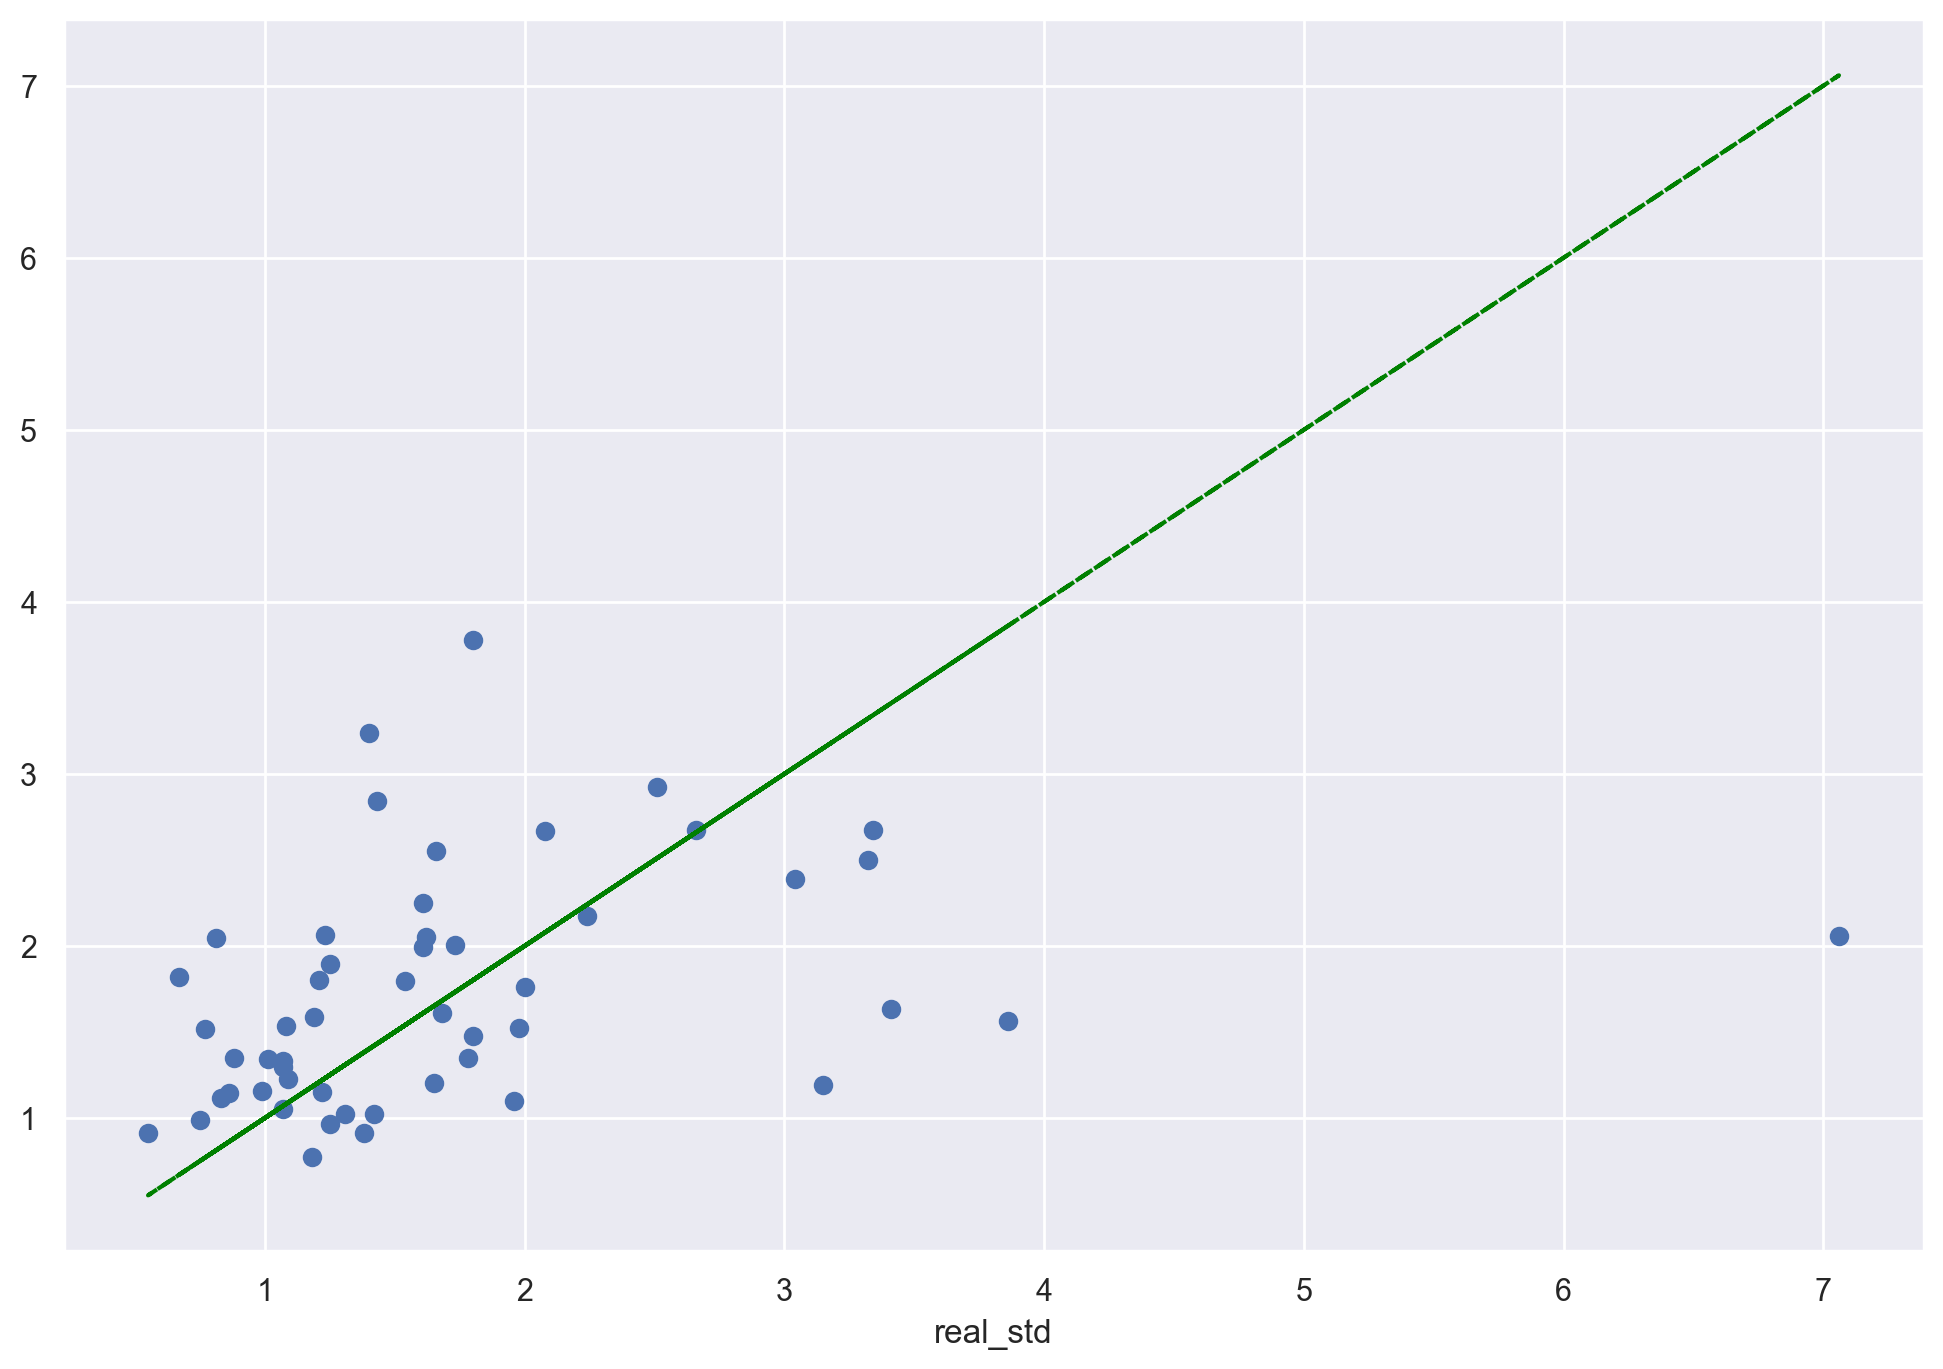

In [34]:
run_model(best_xgb_model,X_train,y_train,X_test,y_test)

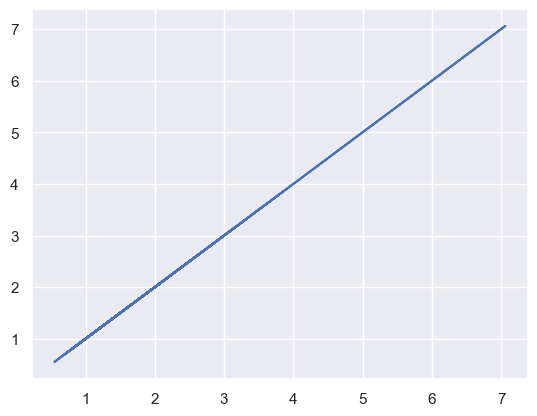

In [35]:
plt.plot(y_test, y_test)

In [36]:
pd.DataFrame(index=X.columns,data=best_xgb_model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
prior_std,0.019265
prior_Vol,0.035960
prior_spread,0.035419
prior_range,0.036621
cut_close,0.015796
cut_1hr,0.057910
cut_2hr,0.014451
cut_3hr,0.037979
vix_prior_std,0.065147
vix_pr_spread,0.083486


In [37]:
X_train

,prior_std,prior_Vol,prior_spread,prior_range,cut_close,cut_1hr,cut_2hr,cut_3hr,vix_prior_std,vix_pr_spread,...,vix_cut_2hr,vix_cut_3hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr,tqqq_cut_3hr
160,0.659244,58050.220833,2.81,2.25,227.10,-0.15,0.76,1.31,0.074990,0.29,...,0.18,0.13,0.481776,106464.608333,2.11,1.89,82.02,-0.02,0.26,0.73
196,0.437526,63969.545833,2.01,1.98,243.01,0.13,-0.57,0.46,0.237609,0.91,...,-0.37,-0.35,0.653054,119404.620833,2.47,2.57,82.28,0.50,0.74,1.76
159,0.618190,83034.616667,4.77,4.85,224.19,-0.10,-0.63,-1.49,0.099088,0.57,...,0.10,0.20,0.509029,143217.562500,2.04,2.10,78.45,0.59,0.84,0.60
132,0.527416,64413.658333,2.42,2.05,231.65,-0.44,-0.27,0.71,0.212133,1.20,...,0.73,0.66,0.268391,84125.562500,1.34,1.33,71.44,-0.55,-0.46,-0.02
80,0.639425,98753.787500,4.34,4.36,228.69,0.15,0.01,0.84,0.293286,0.93,...,-0.28,0.32,0.779441,161840.091667,3.14,3.13,74.79,-0.02,-1.15,-1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.375701,77309.900000,2.14,2.15,216.16,0.38,-0.04,-0.24,0.364663,1.37,...,0.21,0.58,0.613568,135023.133333,2.31,2.31,66.51,-0.06,-0.81,-1.16
113,1.091699,67940.112500,5.44,5.47,223.83,-0.05,-0.03,-1.48,0.446311,1.79,...,1.56,1.61,0.926781,162946.462500,3.64,3.46,64.05,0.04,-0.28,-1.56
64,0.452482,163911.933333,2.13,2.15,210.06,-1.05,-0.78,-0.79,0.115272,0.48,...,0.08,-0.19,0.397595,98229.945833,1.71,1.73,74.42,-0.74,-0.19,0.18
15,0.883388,103430.816667,3.94,3.92,172.11,2.22,3.14,3.41,0.451067,1.63,...,-0.79,-1.20,0.503970,175118.475000,2.33,2.33,61.01,1.21,1.67,2.03


In [38]:
import joblib
# Assuming 'model' is your trained model object
filename = 'xgb_model_AAPL_price_spread_update.joblib'
joblib.dump(best_xgb_model, filename)


['xgb_model_AAPL_price_spread_update.joblib']

In [ ]:
pwd

----